
# **Bibliotecas necessárias**

In [2]:
!pip install twitter
!pip install snscrape

     |████████████████████████████████| 50 kB 2.7 MB/s 


In [3]:
import snscrape.modules.twitter as sntwitter
import csv
import pandas as pd
import numpy as np
import re
import nltk
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import string
import keras 
import tensorflow as tf

from keras import utils
from keras.layers import LeakyReLU
#############################################
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
#from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
#############################################


from unicodedata import normalize

from string import punctuation

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.linear_model import LogisticRegression,SGDClassifier,PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.pipeline import Pipeline

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

#**Funções**

In [4]:
#Função para limpar os tweets utilizando regex
def limparText(twt):
  twt = re.sub('#(\w+)','',twt)
  twt = re.sub('@(\w+)','',twt)
  twt = re.sub('#[A-Za-z0-9]+]','',twt)
  twt = re.sub('\\n','',twt)
  twt = re.sub('https?:\/\/\S+','',twt)
  twt = re.sub('[^\w\s]','',twt)
  twt = re.sub('  ',' ',twt)  
  return twt

##----------------------------------------------------------------------------------------

# Função para remover emoji.
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

##----------------------------------------------------------------------------------------

#Funcao para retirar a acentuação e caracteres especiais
def removerCaracteresEspeciais(text) :
        return normalize('NFKD', text).encode('ASCII', 'ignore').decode('ASCII')

In [5]:
#função para visualizar a matriz de confusão
def plot_confusion_matrix(cm, classes, normalize=False, title='Matriz de confusão', cmap=plt.cm.Greys):
    """
    Source: 
         http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    Input:
         cm: confusion matrix
         classes: output classes name
         normalize: normalization can be applied by setting `normalize=True`
    
    Output:
         This function prints and plots the confusion matrix.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.set_cmap('Greys')
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="green" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Real')
    plt.xlabel('Preditos')

#**Carregando dados**

## Carregando novos Tweets para o experimento no final
Carregando novos twets para o experimento no final do notebook, eles estão sendo carregados aqui para que possam ser aplicadas as tratativas nos textos juntamente com os dados do treino e teste.

In [6]:
# Quantidade máxima de tweets
maxTweets = 1000
csvFile = open('TweetsExperimento.csv', 'w', newline='', encoding='utf8')

csvWriter = csv.writer(csvFile)
csvWriter.writerow(['tweetId','texto_original'])

tweets_list1 = []
for i, tweet in enumerate(sntwitter.TwitterSearchScraper('Correios + lang:pt + since:2018-01-01 until:2018-12-31 -filter:links -filter:replies -filter:retweets').get_items()):#.filter(tweet.id!=dfid['id']): #and sntwitter.TwitterSearchScraper.get_items(id) != dfid['id']:
#for i, tweet in enumerate(sntwitter.TwitterSearchScraper('Correios + lang:pt + since:2021-08-31 until:2021-12-31 -filter:links -filter:replies -filter:retweets').get_items()):#.filter(tweet.id!=dfid['id']): #and sntwitter.TwitterSearchScraper.get_items(id) != dfid['id']:
      if i > maxTweets:
          break
      csvWriter.writerow([tweet.id,tweet.content])
csvFile.close()

In [7]:
# Leitura do arquivo csv criado
df_experimento = pd.read_csv("TweetsExperimento.csv", names=['tweetId','texto_original'] , header= 1)
# Definição do tamanho máximo da coluna e quantidade de linhas para visualização de todos os caracteres, sem restrição
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', df_experimento.shape[0]+1)
#Tirando linhas em branco
mensagem = df_experimento.dropna(subset=['texto_original'], axis=0)['texto_original']
#Removendo duplicadas
df_experimento.drop_duplicates(keep='first', inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


In [8]:
df_experimento['Categoria'] = 'Experimento'
#df_experimento = df_experimento.loc['Experimento'] = 'Experimento'

##Carregando os dados utilizados no treino/teste
Carregando a base que o grupo categorizou como negativo, neutro e positivo


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
pd.set_option('display.max_colwidth', -1)
#df_completo = pd.read_csv('dadosTweetsCorreios_D_2.csv', sep=';', encoding ='unicode_escape')
df_completo = pd.read_csv('dadosTweetsCorreios_Final_1.csv', sep=';', encoding ='unicode_escape')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [11]:
#Mantendo o df_completo para situações futuras
df = df_completo.drop(columns=['Obs','Item','tweetId'])
df_experimento = df_experimento.drop('tweetId',axis=1)
#Juntando a base do experimento final com a base que será usada no treino, teste e validação
df =pd.concat([df,df_experimento], ignore_index=True)

In [12]:
#Criando novas colunas (texto e num_cat) para trabalhar e ter a referência do original quando necessário
df['texto'] = df['texto_original']
df['num_cat'] = df['Categoria'] 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17001 entries, 0 to 17000
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   texto_original  17001 non-null  object
 1   Categoria       13447 non-null  object
 2   texto           17001 non-null  object
 3   num_cat         13447 non-null  object
dtypes: object(4)
memory usage: 531.4+ KB


#**Tratando os dados e balanceando a base**

##Aplicando as tratativas necessárias nos textos

*   Transformando texto para minúsculo;
*   Remoção de letras repetidas, stopwords, emojis, quebras de linha, acentuação, caracteres especiais e palavras com menos de 3 caracteres.  



In [13]:
#Transformando tudo para minúsculo
df['texto'] = df['texto'].str.lower()

##----------------------------------------------------------------------------------------
#removendo todas as letras repetidas (Ex.: correio->coreio)
f = lambda x: ''.join(ch for ch, _ in itertools.groupby(x))
df['texto'] = df['texto'].apply(f)

##----------------------------------------------------------------------------------------

# Definição de stopwords personalizadas e que não estão na bibliotega "gensim" 
stopwords_ptbr = nltk.corpus.stopwords.words('portuguese')
stopwords = set(stopwords_ptbr)
#mantendo o "não" nos textos
stopwords.remove('não')
#lista de stopwords personalizada
stopwords.update(['coreio','correio', 'correios','coreios', 'pra', 'pro', 'mds', 'mrm','esa',\
                  'poa','vou','ter','dnv','tao','ufa','iso', 'vai', 'ser','ces', 'ctz', 'cmg', \
                  'ano', 'fzr'])           
pat = r'\b(?:{})\b'.format('|'.join(stopwords))
#aplicando o stopword e mantendo palavras que contenham mais de 3 caracteres.
df['texto'] = df['texto'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords) and len(word) > 2]))

#Aplicando as funções que irão tratar as frases
#limpando o texto (removendo quebra de linhas careact)
df['texto'] = df['texto'].map(lambda x: limparText(x))
#Removendo acentuação e caracteres especiais
df['texto'] = df['texto'].apply(removerCaracteresEspeciais)
#removendo os emoji's
df['texto'] = df['texto'].apply(remove_emoji)

#Verificando como ficou o texto após as tratativas de remoção de pontuação, caracteres especiais, retirada de emojis, retirada dos stopwords 
# e de palavras com menos de 3 caracteres, colocar todo o texto em caixa baixa.
#df['texto']

In [14]:
#Após as tratativas removendo novamente com stopwords sujeiras que podem ter se formado ou palavras que podem ter ficado com menos de 3 caracteres
df['texto'] = df['texto'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 2]))

In [15]:
#Tratando a coluna num_cat para que ela possa colocar os valores corretos para cada rótulo
df.loc[df['Categoria'] == 'Negativo', 'num_cat'] = -1
df.loc[df['Categoria'] == 'Neutro', 'num_cat'] = 0
df.loc[df['Categoria'] == 'Positivo', 'num_cat'] = 1

In [16]:
#Guardando um df completo tratado para situações futuras 
df_tratado = df

##Analisando a base de dados
Separando a base em quantidades iguais para cada categoria para garantir o balanceamento

In [17]:
#Verificando o balanceamento da base
df['Categoria'].value_counts()

Negativo       5536
Neutro         4187
Positivo       2715
Experimento    1000
neutro         9   
Name: Categoria, dtype: int64

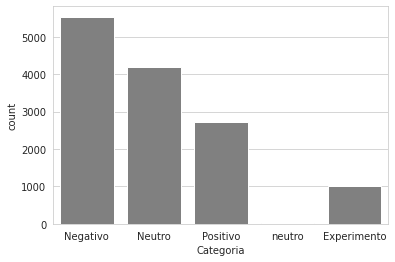

In [18]:
#Verificando como está o balanceamento da base
sns.set_style('whitegrid')
sns.countplot(x='Categoria',data=df, color='grey')

In [19]:
#Determinando os núremos de corte de forma automática, para que tenhamos sempre um total de 900, sendo 300 de cada categoria na validação.
#Usada a base de positivo pois sempre foi a menor durante o tempo de desenvolvimento
#qtd1 - é o total de positivos - 300
#qtd2 - é o total de positivos 
qtd1 = len(df.query('Categoria == "Positivo"'))-300
qtd2 = len(df.query('Categoria == "Positivo"'))

#Separando as categorias para dividir em treino, teste e validação.
df_neg = df.query('Categoria == "Negativo"')
df_neu = df.query('Categoria == "Neutro"')
df_pos = df.query('Categoria == "Positivo"')
#Resetando o index
df_neg.reset_index(drop=False, inplace=True)
df_neu.reset_index(drop=False, inplace=True)
df_pos.reset_index(drop=False, inplace=True)
#Separando em quantidades iguais as categorias: Negativo,Neutro e Positivo, para garantir o balanceamento
df_0 = df_neg.query('Categoria == "Negativo"').loc[0:qtd1]
df_1 = df_neu.query('Categoria == "Neutro"').loc[0:qtd1]
df_2 = df_pos.query('Categoria == "Positivo"').loc[0:qtd1]
#Juntando tudo em um novo dataframe
juntando = [df_0, df_1, df_2]
df = pd.concat(juntando)

In [20]:
#Verifcando como ficou o balanceamento aplicado
df['Categoria'].value_counts()

Negativo    2416
Neutro      2416
Positivo    2416
Name: Categoria, dtype: int64

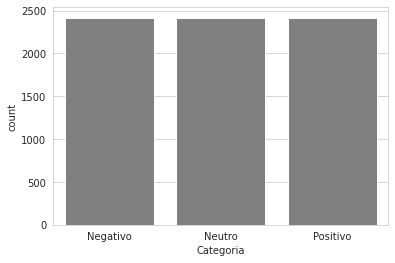

In [21]:
#apresentando a base balanceada
sns.set_style('whitegrid')
sns.countplot(x='Categoria',data=df, color='grey')

# **Área de Treino e Teste dos modelos**
Foram criados os modelos de Rede Neural, Logistic Regression, Random Forest, Naive Bayes e Passive Agressive 

## Redes Neurais (TensorFlow)

In [22]:
#Preparando um dataframe para realizar os treinamento com tensorflow
df1 = df[['texto','Categoria']]
#Remover a coluna categoria, colocando-a em linha e aplicando os valores 0 para falso e 1 para verdadeiro.
one_hot = pd.get_dummies(df1["Categoria"])
df1.drop(['Categoria'],axis=1,inplace=True)
df1 = pd.concat([df1,one_hot],axis=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [23]:
df1.head(5)

,texto,Negativo,Neutro,Positivo
0,demoram tanto sapucaia,1,0,0
1,amanha dia enfrentar fila segundafeira,1,0,0
2,toda vez preciso transportadora mini crise diferente queria nao vender nada fisico nao precisar,1,0,0
3,preparando psicologicamente pasar dia horas fila,1,0,0
4,povo bando arombado deixa explicar negocio voces alguem tenta fazer algo legal fode tudo nao vao foder pesoa reclama pora caralho parece nasceram ontem hein,1,0,0


In [24]:
#separando os dados para treino e teste
X=df1['texto'].values
y=df1.drop('texto', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=43)

In [25]:
#vetorizando
bow = CountVectorizer()
X_train = bow.fit_transform(X_train)
X_test = bow.transform(X_test)

In [26]:
#Term Frequency, Inverse Document Frequency
tfidf = TfidfTransformer()
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)
X_train=X_train.toarray()
X_test=X_test.toarray()

In [27]:
#criando o modelo 
model = Sequential()

model.add(Dense(units=1500,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1000,activation='elu'))
model.add(Dropout(0.5))

#model.add(Dense(units=50,activation='ThresholdedReLU'))
#model.add(Dropout(0.5))

#model.add(LeakyReLU(alpha=0.1))
#model.add(Dropout(0.5))

model.add(Dense(units=1000,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=500,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=3, activation='softmax'))

opt=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [28]:
#configurando a regra para dar o stop na execução do modelo
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [29]:
#executando o treinamento
history = model.fit(x=X_train, y=y_train, batch_size=550, epochs=100, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stop])

Epoch 1/100
11/11 [==============================] - 10s 815ms/step - loss: 1.0595 - accuracy: 0.4383 - val_loss: 0.7748 - val_accuracy: 0.7076
Epoch 2/100
11/11 [==============================] - 9s 783ms/step - loss: 0.6014 - accuracy: 0.7646 - val_loss: 0.5989 - val_accuracy: 0.7862
Epoch 3/100
11/11 [==============================] - 9s 779ms/step - loss: 0.2517 - accuracy: 0.9088 - val_loss: 0.6503 - val_accuracy: 0.7766
Epoch 4/100
11/11 [==============================] - 9s 779ms/step - loss: 0.0988 - accuracy: 0.9698 - val_loss: 0.9021 - val_accuracy: 0.7579
Epoch 00004: early stopping


In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1500)              12981000  
_________________________________________________________________
dropout (Dropout)            (None, 1500)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              1501000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 500)               5

In [31]:
df_m=pd.DataFrame(model.history.history)
#df_m['Epoch']=range(0,4)
#df_m.index=df_m['Epoch']
df_m

,loss,accuracy,val_loss,val_accuracy
0,1.059533,0.438255,0.774776,0.707586
1,0.601382,0.764574,0.598943,0.786207
2,0.251727,0.908762,0.650290,0.776552
3,0.098831,0.969817,0.902094,0.757931


In [32]:
#Verificando a acuracia do resultado da massa de dados separados para o teste
score = model.evaluate(X_test, y_test, batch_size=550, verbose=1)
print('Accuracy do teste:', score[1])

3/3 [==============================] - 1s 271ms/step - loss: 0.9021 - accuracy: 0.7579
Accuracy do teste: 0.7579310536384583


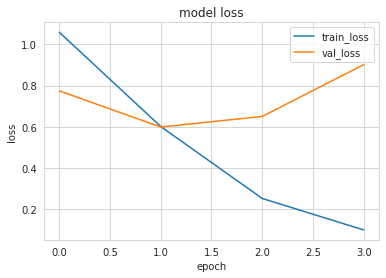

In [33]:
#Loss gráfico (treino e teste)
plt.plot(df_m['loss'])
plt.plot(df_m['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

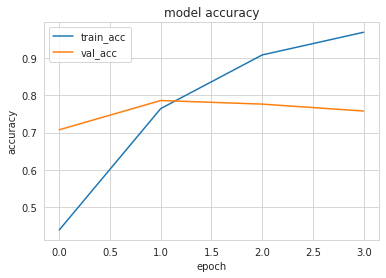

In [34]:
# Accuracy gráfico (treino e teste)
plt.plot(df_m['accuracy'])
plt.plot(df_m['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'])
plt.show()

Confusion matrix, without normalization


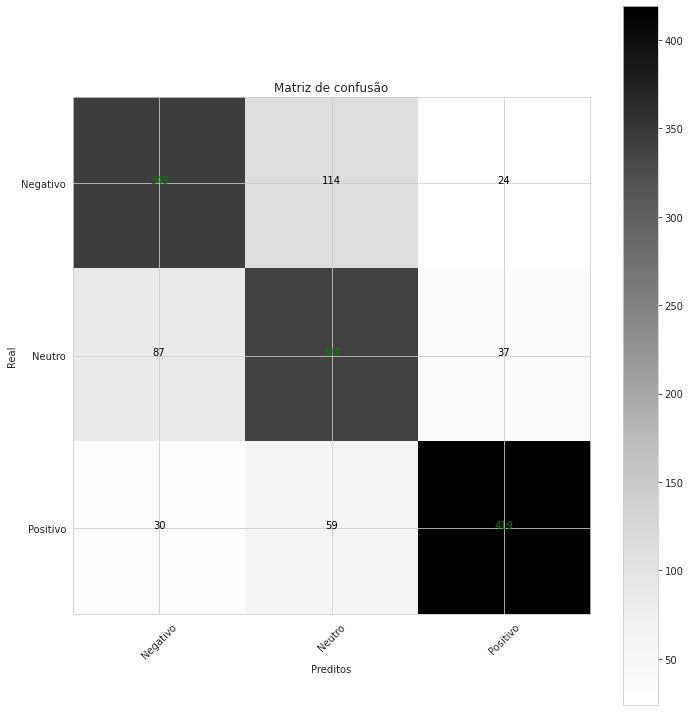

In [35]:
#Realizando a predição na massa de teste
preds = model.predict(X_test)

#Visualizar na matriz de confusão o resultado da predição da massa de teste
cm=confusion_matrix(np.argmax(y_test,axis=1), np.argmax(preds,axis=1))
plot_confusion_matrix(cm, classes=['Negativo', 'Neutro', 'Positivo'])

In [36]:
#Verificando o resultado do modelo 
#print(confusion_matrix(np.argmax(y_test,axis=1),np.argmax(preds,axis=1)))
data = classification_report(np.argmax(y_test,axis=1),np.argmax(preds,axis=1),target_names=['Negativo','Neutro','Positivo'])
print(data)

              precision    recall  f1-score   support

    Negativo       0.75      0.71      0.73       481
      Neutro       0.66      0.73      0.69       461
    Positivo       0.87      0.82      0.85       508

    accuracy                           0.76      1450
   macro avg       0.76      0.76      0.76      1450
weighted avg       0.76      0.76      0.76      1450



## Bag of words e separando dados para treino e teste dos modelos abaixo

In [37]:
#Separando o conteúdo categorizado para aplicar nos modelos abaixo
df2 = df[df["num_cat"].between(-1,1)].drop(columns=['texto_original',	'num_cat']).query('texto != ""')

In [38]:
cv=CountVectorizer(max_features=4500, ngram_range=(1,3))
X_count=cv.fit_transform(df2['texto']).toarray()
y = df2['Categoria']
X_train, X_test, y_train, y_test=train_test_split(X_count, y, test_size=0.20, random_state=0)

## Logistic Regression


In [39]:
lr=LogisticRegression(random_state=0, solver='saga', max_iter=5000)

In [40]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [41]:
pred_lr_count=lr.predict(X_test)

In [42]:
accuracy_score(y_test, pred_lr_count)

0.7632850241545893

In [43]:
cm=confusion_matrix(y_test, pred_lr_count)

Confusion matrix, without normalization


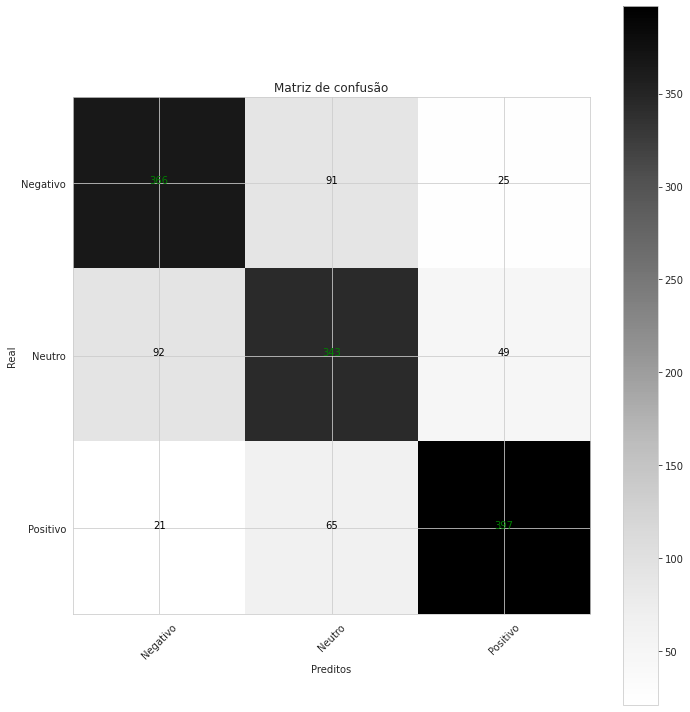

In [44]:
plot_confusion_matrix(cm, classes=['Negativo', 'Neutro', 'Positivo'])

In [45]:
print(classification_report(y_test, pred_lr_count))

              precision    recall  f1-score   support

    Negativo       0.76      0.76      0.76       482
      Neutro       0.69      0.71      0.70       484
    Positivo       0.84      0.82      0.83       483

    accuracy                           0.76      1449
   macro avg       0.76      0.76      0.76      1449
weighted avg       0.76      0.76      0.76      1449





---



## Random forest

In [46]:
rf=RandomForestClassifier(random_state=0)

In [47]:
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [48]:
pred_rf_count=rf.predict(X_test)

Confusion matrix, without normalization


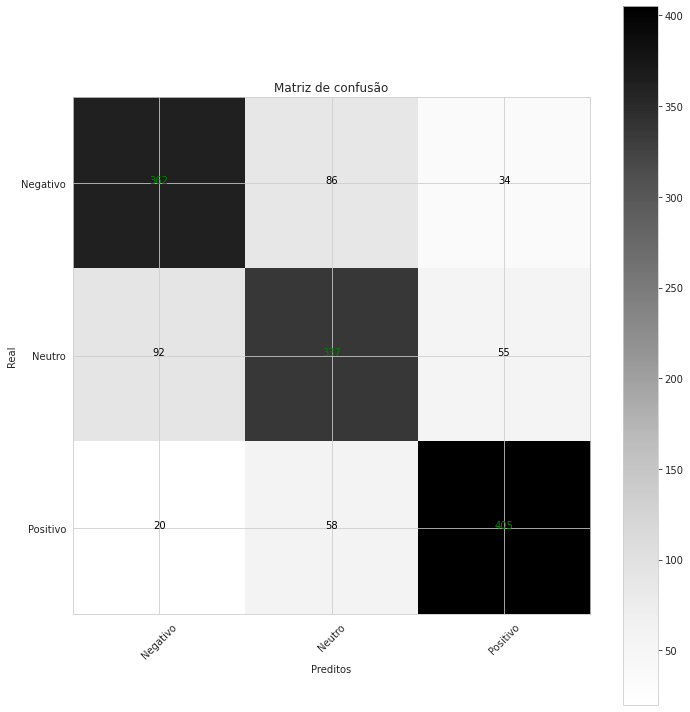

In [49]:
cm=confusion_matrix(y_test, pred_rf_count)
plot_confusion_matrix(cm, classes=['Negativo', 'Neutro', 'Positivo'])

In [50]:
print(classification_report(y_test, pred_rf_count))

              precision    recall  f1-score   support

    Negativo       0.76      0.75      0.76       482
      Neutro       0.70      0.70      0.70       484
    Positivo       0.82      0.84      0.83       483

    accuracy                           0.76      1449
   macro avg       0.76      0.76      0.76      1449
weighted avg       0.76      0.76      0.76      1449



## Naive bayes

In [51]:
nb=MultinomialNB(alpha=0.1)

In [52]:
nb.fit(X_train, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [53]:
pred_nb_count=nb.predict(X_test)

Confusion matrix, without normalization


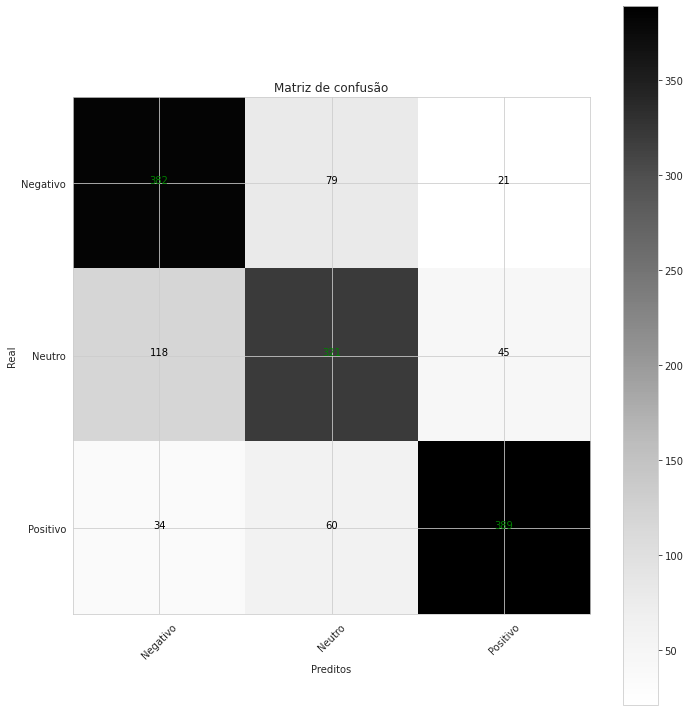

In [54]:
cm=confusion_matrix(y_test, pred_nb_count)
plot_confusion_matrix(cm, classes=['Negativo', 'Neutro', 'Positivo'])

In [55]:
print(classification_report(y_test, pred_nb_count))

              precision    recall  f1-score   support

    Negativo       0.72      0.79      0.75       482
      Neutro       0.70      0.66      0.68       484
    Positivo       0.85      0.81      0.83       483

    accuracy                           0.75      1449
   macro avg       0.76      0.75      0.75      1449
weighted avg       0.76      0.75      0.75      1449



## Passive aggressive

In [56]:
pa=PassiveAggressiveClassifier(max_iter=5000)

In [57]:
pa.fit(X_train, y_train)

PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=5000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False)

In [58]:
pred_pa_count=pa.predict(X_test)

Confusion matrix, without normalization


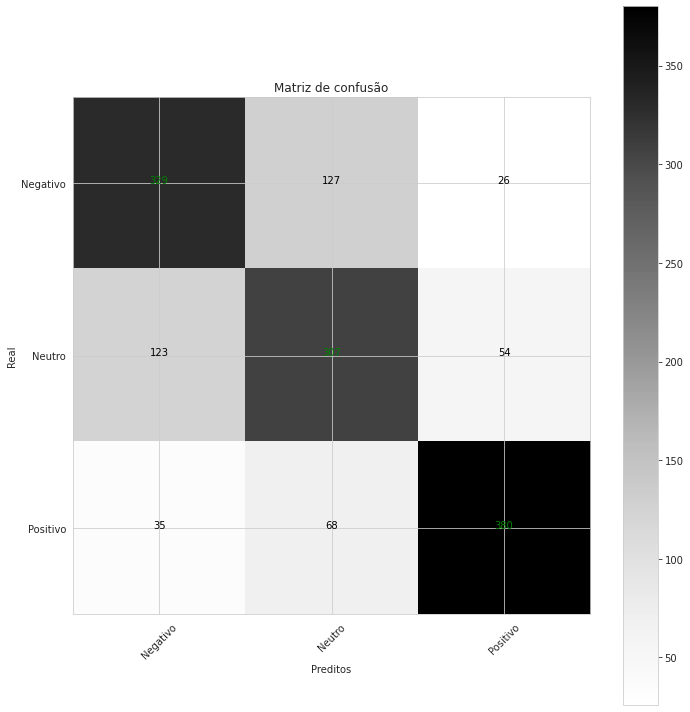

In [59]:
cm=confusion_matrix(y_test, pred_pa_count)
plot_confusion_matrix(cm, classes=['Negativo', 'Neutro', 'Positivo'])

In [60]:
print(classification_report(y_test, pred_pa_count))

              precision    recall  f1-score   support

    Negativo       0.68      0.68      0.68       482
      Neutro       0.61      0.63      0.62       484
    Positivo       0.83      0.79      0.81       483

    accuracy                           0.70      1449
   macro avg       0.70      0.70      0.70      1449
weighted avg       0.70      0.70      0.70      1449



---
# **Área de Validação**

## Aplicando nos modelos os dados categorizados que não foram utilizados no treino e no teste na fase anterior

In [61]:
#Separando em quantidades iguais (negativa, neuro e positiva), apenas as 
#que já estão categorizadas e não foram usadas para treino e teste.
df_3 = df_neg.query('Categoria == "Negativo"').loc[qtd1:qtd2-1]
df_4 = df_neu.query('Categoria == "Neutro"').loc[qtd1:qtd2-1]
df_5 = df_pos.query('Categoria == "Positivo"').loc[qtd1:qtd2]
juntando = [df_3, df_4, df_5]
df_validacao = pd.concat(juntando, ignore_index=True)
df_validacao = df_validacao.drop(columns=['num_cat','index'])
#Refazendo o index
df_validacao = df_validacao.query('texto != ""')
df_validacao = df_validacao.dropna()
df_validacao.reset_index(drop=False, inplace=True)

## Bag of Words do dataframe com os dados de validação e aplicação dos modelos

In [62]:
cv=CountVectorizer(max_features=4500, ngram_range=(1,3))
X_count=cv.fit_transform(df_validacao['texto']).toarray()

In [63]:
#Aplicando a Regressão Logística
pred_lr_count=lr.predict(X_count)
#Separando apenas o resultado predito 
PRED_LR = pd.DataFrame(pred_lr_count, columns=['PRED_LR'])
#PRED.reset_index(drop=False, inplace=True)

In [64]:
#Aplicando o Random Forest
pred_rf_count=rf.predict(X_count)
#Separando apenas o resultado predito 
PRED_RF = pd.DataFrame(pred_rf_count, columns=['PRED_RF'])
#PRED.reset_index(drop=False, inplace=True)

In [65]:
#Aplicando o Naive Bayes
pred_nb_count=nb.predict(X_count)
#Separando apenas o resultado predito
PRED_NB = pd.DataFrame(pred_nb_count, columns=['PRED_NB'])
#PRED.reset_index(drop=False, inplace=True)

In [66]:
#Aplicando o Passive Aggressive
pred_pa_count=pa.predict(X_count)
#Separando apenas o resultado predito
PRED_PA = pd.DataFrame(pred_pa_count, columns=['PRED_PA'])
#PRED.reset_index(drop=False, inplace=True)

In [100]:
#preparando um dataframe para realizar os testes com tensorflow
dfa = df_validacao[['texto','Categoria']].query('texto != ""')
#remover a coluna categoria, colocando-a em linha e aplicando os valores 0 para falso e 1 para verdadeiro.
one_hot = pd.get_dummies(dfa["Categoria"])
dfa.drop(['Categoria'],axis=1,inplace=True)
dfa = pd.concat([dfa,one_hot],axis=1)
#dfa.head()

#Vetorizando
val=dfa['texto'].values
val_f = bow.transform(val)

#Term Frequency, Inverse Document Frequency
val_f = tfidf.fit_transform(val_f)
val_f = val_f.toarray()
#Aplicando a predição da rede neural
preds = model.predict(val_f)
#Separando apenas o resultado predito
PRED_RN = pd.DataFrame(preds, columns=['Negativo','Neutro','Positivo'])
#Organizando em uma única coluna os resultados
PRED_RN.loc[((PRED_RN['Negativo'] > PRED_RN['Neutro']) & (PRED_RN['Negativo'] > PRED_RN['Positivo'])),'PRED_RN'] = 'Negativo' 
PRED_RN.loc[((PRED_RN['Neutro'] > PRED_RN['Negativo']) & (PRED_RN['Neutro'] > PRED_RN['Positivo'])),'PRED_RN'] = 'Neutro'  
PRED_RN.loc[((PRED_RN['Positivo'] > PRED_RN['Neutro']) & (PRED_RN['Positivo'] > PRED_RN['Negativo'])),'PRED_RN'] = 'Positivo' 


In [101]:
#Juntando todos os dados das prediçãos realizada (RL/RF/NB/PAC/RN) com a massa de validação e a coluna Categoria com a informação que correta.
saida_completa = pd.concat([df_validacao['texto_original'],df_validacao['texto'],df_validacao['Categoria'],PRED_RN,PRED_LR,PRED_RF,PRED_NB,PRED_PA], axis=1,) \
            [['texto_original','texto','Categoria','PRED_RN','PRED_LR', 'PRED_RF','PRED_NB','PRED_PA']]

In [ ]:
#Visualizando uma parte dos dados
#saida_completa.loc[0:899].sample(300)
saida_completa.loc[0:899].query('Categoria == "Negativo"').sample(30)
#saida_completa.loc[0:899].query('Categoria == "Neutro"').sample(30)
#saida_completa.loc[0:899].query('Categoria == "Positivo"').sample(30)

##Quantitativos e Percentuais de acerto dos modelos
Verificando qual modelo apresentou melhores resultado.

In [102]:
#Montando a tabela de qtd classificada corretamente
saida_completa.insert(loc=1, column='sent', value=1)
names_1 = list(saida_completa.columns[1:])
names_2 = list(saida_completa.columns[3:])
np_col=saida_completa['Categoria'].to_numpy()
calclist = [np.where(saida_completa['Categoria']==saida_completa[col], 1, 0) for col in saida_completa.columns[2:]]
calclist.insert(0, np_col)
dic = dict(zip(names_1, calclist))
df_dic = pd.DataFrame(dic)
cont_2 = df_dic.groupby(by=['sent'],
                          as_index=True).agg({'Categoria': 'sum', 'PRED_RN': 'sum', 'PRED_LR': 'sum','PRED_RF': 'sum', 'PRED_NB': 'sum', 'PRED_PA': 'sum'})
cont_2.rename(columns={'Categoria': 'TOTAL'}, inplace=True)

#-------------------------------------------------------------------
#Montando a tabela de percentuais de acertos
percent = [round(cont_2[col] / cont_2['TOTAL'] * 100,2) for col in cont_2.columns]
tab_perc = pd.DataFrame().join(percent, how="outer").fillna(0)
tab_perc.set_axis(names_2, axis=1, inplace=True)
tab_perc.drop('Categoria', axis=1, inplace=True)

In [105]:
print('\x1b[1;34m'+'QTDE. CLASSIFICADA CORRETAMENTE'.center(65)+'\x1b[0m')
cont_2

                 QTDE. CLASSIFICADA CORRETAMENTE                 


,TOTAL,PRED_RN,PRED_LR,PRED_RF,PRED_NB,PRED_PA
sent,,,,,,
Negativo,300,174,78,98,61,87
Neutro,298,216,193,184,143,162
Positivo,300,230,48,84,149,47


In [104]:
print('\x1b[1;34m'+'PERCENTUAIS DE ACERTOS'.center(60)+'\x1b[0m')
tab_perc

                   PERCENTUAIS DE ACERTOS                   


,PRED_RN,PRED_LR,PRED_RF,PRED_NB,PRED_PA
Negativo,58.00,26.00,32.67,20.33,29.00
Neutro,72.48,64.77,61.74,47.99,54.36
Positivo,76.67,16.00,28.00,49.67,15.67


---
# **Área de Experimento**
Essa área e destinada a análise dos tweets que foram carregados no ínicio do processamento, será utilizando o modelo de Rede Neural com tensorflow que apresentou melhores resultados.


In [73]:
#buscando dados do df_tratado
df_experimento_final = df_tratado.query('Categoria == "Experimento"').drop('num_cat', axis=1)
df_experimento_final.reset_index(drop=False, inplace=True)

In [74]:
#Vetorizando
val=df_experimento_final['texto'].values
val_f = bow.transform(val)

#Term Frequency, Inverse Document Frequency
val_f = tfidf.fit_transform(val_f)
val_f = val_f.toarray()
#Aplicando a predição da rede neural
preds = model.predict(val_f)

In [75]:
#Separando apenas o resultado predito
PRED_FINAL = pd.DataFrame(preds, columns=['Negativo','Neutro','Positivo'])
#Organizando em uma única coluna os resultados
PRED_FINAL.loc[((PRED_FINAL['Negativo'] > PRED_FINAL['Neutro']) & (PRED_FINAL['Negativo'] > PRED_FINAL['Positivo'])),'PRED_FINAL'] = 'Negativo' 
PRED_FINAL.loc[((PRED_FINAL['Neutro'] > PRED_FINAL['Negativo']) & (PRED_FINAL['Neutro'] > PRED_FINAL['Positivo'])),'PRED_FINAL'] = 'Neutro'  
PRED_FINAL.loc[((PRED_FINAL['Positivo'] > PRED_FINAL['Neutro']) & (PRED_FINAL['Positivo'] > PRED_FINAL['Negativo'])),'PRED_FINAL'] = 'Positivo' 

In [76]:
#Juntando os dados das prediçãos realizada com o modelo que achamos melhor, classificação utilizando rede neural (Tensorflow) com os dados coletados no tweet.
saida_final = pd.concat([df_experimento_final['texto_original'],df_experimento_final['texto'],PRED_FINAL], axis=1,)[['texto_original','texto','PRED_FINAL']]

In [77]:
#Exibindo 50 linhas aleatórias
saida_final.loc[0:299].sample(300)

,texto_original,texto,PRED_FINAL
32,"pra mim correios tinha que trabalhar todo dia, pra deixar de entregar as coisas atrasado",mim trabalhar todo dia deixar entregar coisas atrasado,Negativo
226,depois do cara dos correios ser imensamente grosso comigo chego no carro e por um minuto ele não eh rebocado sextou,cara imensamente groso comigo chego caro minuto nao rebocado sextou,Negativo
11,Eu animadíssimaaaaaa\n2 mins dps lembrei que seria impossível pois os correios podem foder com tudo já que tratam as encomendas feitos ogrooos ai que raiva,animadisima mins dps lembrei imposivel pois podem foder tudo tratam encomendas feitos ogros raiva,Negativo
36,Meu relógio do Edward já chegou :c mas os correios estão fechados pra virada do ano.\n\nEu vou pegar ele só na quarta ou na quinta :c,relogio edward chegou fechados virada ano pegar quarta quinta,Positivo
94,a desgraça dos Correios devolveu minha mercadoria que eu to esperando a 3 meses pra China,desgraca devolveu mercadoria esperando meses china,Negativo
250,tomara que segunda os correios entregue meus anéis,tomara segunda entregue aneis,Negativo
162,Queria uma boa notícia dos correios... Só uma...,queria boa noticia coreios uma,Neutro
258,Eu fico imaginando quem pede privatização dos Correios certamente não passou raiva com transportadora.,fico imaginando pede privatizacao certamente nao pasou raiva transportadora,Neutro
292,minhas arma me acordaram pra assinar um papel e de tarde meu pai vai nos correios retirar,arma acordaram asinar papel tarde pai retirar,Neutro
48,"N preciso pombos correios, obg😀",preciso pombos coreios obg,Neutro


In [78]:
##GERAR ARQUIVOS DE SAÍDA COM O CONTEÚDO BAIXADO NO MOMENTO DA EXECUÇÃO DO NOTEBOOK
#saida_final_Neg = saida_final.query('PRED_FINAL == "Negativo"').dropna()
#saida_final_Neu = saida_final.query('PRED_FINAL == "Neutro"').dropna()
#saida_final_Pos = saida_final.query('PRED_FINAL == "Positivo"').dropna()

#saida_final_Neg.to_csv('Novos_Negativos.csv')
#saida_final_Neu.to_csv('Novos_Neutros.csv')
#saida_final_Pos.to_csv('Novos_Positivos.csv')